# Exercise 5 - Convolutional Neural Networks and the MNIST dataset
This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow

In this exercise we want to solve the same multinomial classification problem as in last weeks exercise 4 using the MNIST dataset, but this time we want to use a convolutional neural network for it.


As usual we will load tensorflow 2 first and make sure we change our runtime to python 3:

In [129]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  %tensorflow_version 2.x

#import TF
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Tensorflow version 2.12.0
Python version = 3.11.5


Before we start, we define a few useful functions, which we used in exercise 4:

In [130]:
###################################################################################################

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

###################################################################################################

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###################################################################################################
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

###################################################################################################


## Data Preparation

### Very Important:
When dealing with images & convolutions, you need to handle the `image_data_format` properly, i.e. is the channel given first or last. The channel axis is an additional dimension of the input data used to access different views of the date, e.g. red/green/blue of a color image, left or right of a stereo sound file).
For grayscale data, the channel dimension is 1, for rgb it should be 3.

In [131]:
from tensorflow.keras import backend as K # type: ignore
K.image_data_format()

'channels_last'

In [132]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

In [133]:
shape_ord

(28, 28, 1)

### Task 1: Data preprocessing
* Load the mnist data of the keras datasets
* Scale the design matrix to values between 0 and 1
* Convert the design matrix to the expected (60000, 28, 28, 1) shape
* Convert the target vector to one-hot-vectors for the 10 classes
* Split the training data into 70% training and 30% validation data sets

*hints*:
- remember the function from `tensorflow.keras.utils` you used in Exercise 4 to convert integer labels to one-hot-vectors
- pay attention to the input when scaling the desing matrix!  

### Loading Data

In [134]:
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

n_classes = 10
Y_train = to_categorical(Y_train, n_classes)
Y_test = to_categorical(Y_test, n_classes)

## A simple convolutional neural network

#### Convolution2D

Convolution layers learn a set of *kernels* that they apply to the data. Our grayscale image have one channel. A 3x3 kernel trained on this data with 1 channel has 10 trainable parameters (3\*3\*1 weights + 1 bias weight for the output). If a 3x3 kernel is trained on e. g. data with 3 channels, this results in 3\*3\*3 +1 = 28 weights. A Conv-Layer can learn more than just one kernel. The number of different kernels are the number of *filters* passed to the layer constructor. Each filter produces an output channel from the input data.

<img src=https://cntk.azurewebsites.net/jup/cntk103d_conv2d_final.gif width=300></img>
(taken from [CNTK Documentation](https://cntk.azurewebsites.net/pythondocs/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.html))
```python
from tensorflow.keras.layers import Conv2D

Conv2D(filters, kernel_size, strides=(1, 1), padding='valid',
       data_format=None, dilation_rate=(1, 1), activation=None,
       use_bias=True, kernel_initializer='glorot_uniform',
       bias_initializer='zeros', kernel_regularizer=None,
       bias_regularizer=None, activity_regularizer=None,
       kernel_constraint=None, bias_constraint=None)
```

#### Arguments:

<ul>
<li><strong>filters</strong>: Integer, the dimensionality of the output space
    (i.e. the number output of filters in the convolution).</li>
<li><strong>kernel_size</strong>: An integer or tuple/list of 2 integers, specifying the
    width and height of the 2D convolution window.
    Can be a single integer to specify the same value for
    all spatial dimensions.</li>
<li><strong>strides</strong>: An integer or tuple/list of 2 integers,
    specifying the strides of the convolution along the width and height.
    Can be a single integer to specify the same value for
    all spatial dimensions.
    Specifying any stride value != 1 is incompatible with specifying
    any <code>dilation_rate</code> value != 1.</li>
<li><strong>padding</strong>: one of <code>"valid"</code> or <code>"same"</code> (case-insensitive).</li>
<li><strong>data_format</strong>: A string,
    one of <code>channels_last</code> (default) or <code>channels_first</code>.
    The ordering of the dimensions in the inputs.
    <code>channels_last</code> corresponds to inputs with shape
    <code>(batch, height, width, channels)</code> while <code>channels_first</code>
    corresponds to inputs with shape
    <code>(batch, channels, height, width)</code>.
    It defaults to the <code>image_data_format</code> value found in your
    Keras config file at <code>~/.keras/keras.json</code>.
    If you never set it, then it will be "channels_last".</li>
<li><strong>dilation_rate</strong>: an integer or tuple/list of 2 integers, specifying
    the dilation rate to use for dilated convolution.
    Can be a single integer to specify the same value for
    all spatial dimensions.
    Currently, specifying any <code>dilation_rate</code> value != 1 is
    incompatible with specifying any stride value != 1.</li>
<li><strong>activation</strong>: Activation function to use
    (see <a href="https://keras.io/activations/">activations</a>).
    If you don't specify anything, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to the kernel matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
</ul>


Let's load all the layers we will need:

In [135]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D # type: ignore

### Model Definition

In [136]:
# -- Initializing the values for the convolution neural network

nb_epoch = 10  # kept very low! Please increase if you can use a GPU

batch_size = 256
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

We will build a very simple CNN with one Conv2D layer. The output of the Conv2D layer needs to be flatten afterwards to a 1D input for the Dense layer.

In [137]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu',
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 flatten_3 (Flatten)         (None, 21632)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                216330    
                                                                 
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


### Training

In [138]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,
                 epochs=nb_epoch, verbose=1,
                 validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 3s 12ms/step - loss: 0.3335 - accuracy: 0.9096 - val_loss: 0.1544 - val_accuracy: 0.9569
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1211 - accuracy: 0.9671 - val_loss: 0.0913 - val_accuracy: 0.9729
Epoch 3/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0812 - accuracy: 0.9776 - val_loss: 0.0740 - val_accuracy: 0.9765
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0639 - accuracy: 0.9813 - val_loss: 0.0697 - val_accuracy: 0.9774
Epoch 5/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0529 - accuracy: 0.9846 - val_loss: 0.0640 - val_accuracy: 0.9793
Epoch 6/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0445 - accuracy: 0.9875 - val_loss: 0.0596 - val_accuracy: 0.9804
Epoch 7/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0385 - accuracy: 0.9890 - val_loss: 0.0587 - val_accuracy: 0.9810

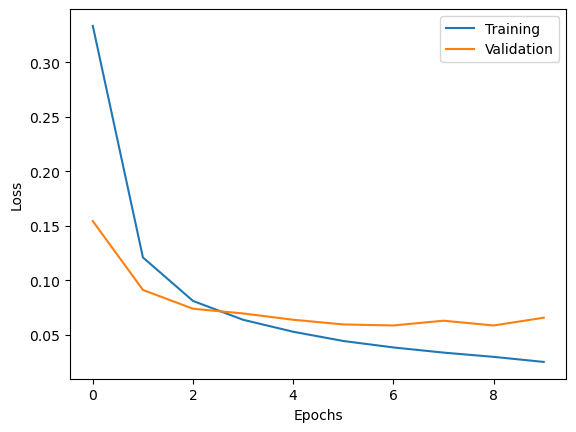

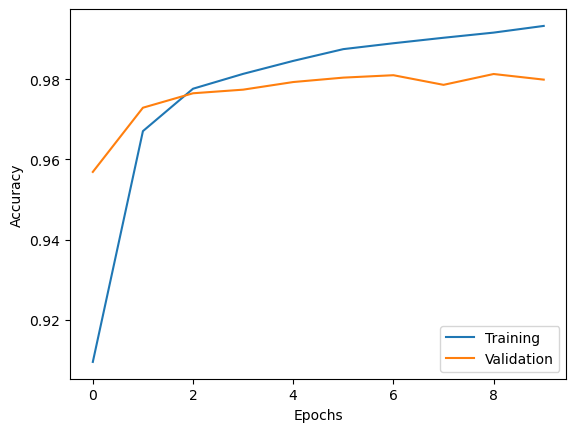

In [139]:
plot_history(hist)

### Task 2: Evaluating - Define an `evaluate` function, with the following properties:
* It takes X_test and Y_test as arguments
* It calculates the loss, the accuracy and the classification report
* It plots the probability of being a zero for true zeros (red) and non-zeros (blue)
* It computes and plots the confusion matrix
* It plots the image, the prediction and the true value for the top 6 errors
* It plots image and predictions for the first 15 examples

In [140]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

def evaluate(X_test, Y_test):
    loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=25)
    print(loss_and_metrics)

    Y_pred = model.predict(X_test)
    Y_pred = Y_pred.argmax(axis=1)
    Y_test = Y_test.argmax(axis=1)

    print(len(Y_pred), len(Y_test), len(X_test))

    confusion_mtx = confusion_matrix(Y_test, Y_pred) 

    print('\n', 'Accuracy Score = ' , accuracy_score(Y_test, Y_pred))
    print('\n', 'Classification Report:')
    print(classification_report(Y_test, Y_pred))

    plot_confusion_matrix(confusion_mtx, normalize=False, classes=range(10))

    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    axs = axs.ravel()

    k = 0
    for i in range(4):
        for j in range(4):
            axs[k].imshow(X_test[k].reshape(28, 28), cmap='gray')
            axs[k].set_title(f"True: {Y_test[k]}, Predicted: {Y_pred[k]}")
            axs[k].grid()
            k += 1

    fig.tight_layout()
    plt.show()

    # Plot probability of being a zero for true zeros (red) and non-zeros (blue)
    prob_zeros = Y_pred[Y_test == 0]
    prob_non_zeros = Y_pred[Y_test != 0]

    plt.hist(prob_zeros, bins=10, color='red', alpha=0.5, label='True Zeros')
    plt.hist(prob_non_zeros, bins=10, color='blue', alpha=0.5, label='Non-Zeros')
    plt.xlabel('Probability of Being Zero')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Find the indices of the top 6 errors
    errors = np.where(Y_pred != Y_test)[0][:6]

    # Plot the top 6 errors
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.ravel()

    for i, error in enumerate(errors):
        axs[i].imshow(X_test[error].reshape(28, 28), cmap='gray')
        axs[i].set_title(f"True: {Y_test[error]}, Predicted: {Y_pred[error]}")
        axs[i].grid()

    fig.tight_layout()
    plt.show()

400/400 [==============================] - 0s 885us/step - loss: 0.0658 - accuracy: 0.9799
[0.06581386178731918, 0.9799000024795532]
313/313 [==============================] - 0s 838us/step
10000 10000 10000

 Accuracy Score =  0.9799

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.96      0.99      0.97      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.96      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98   

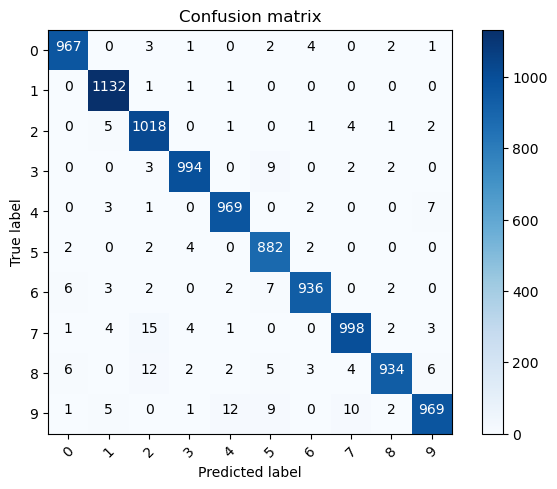

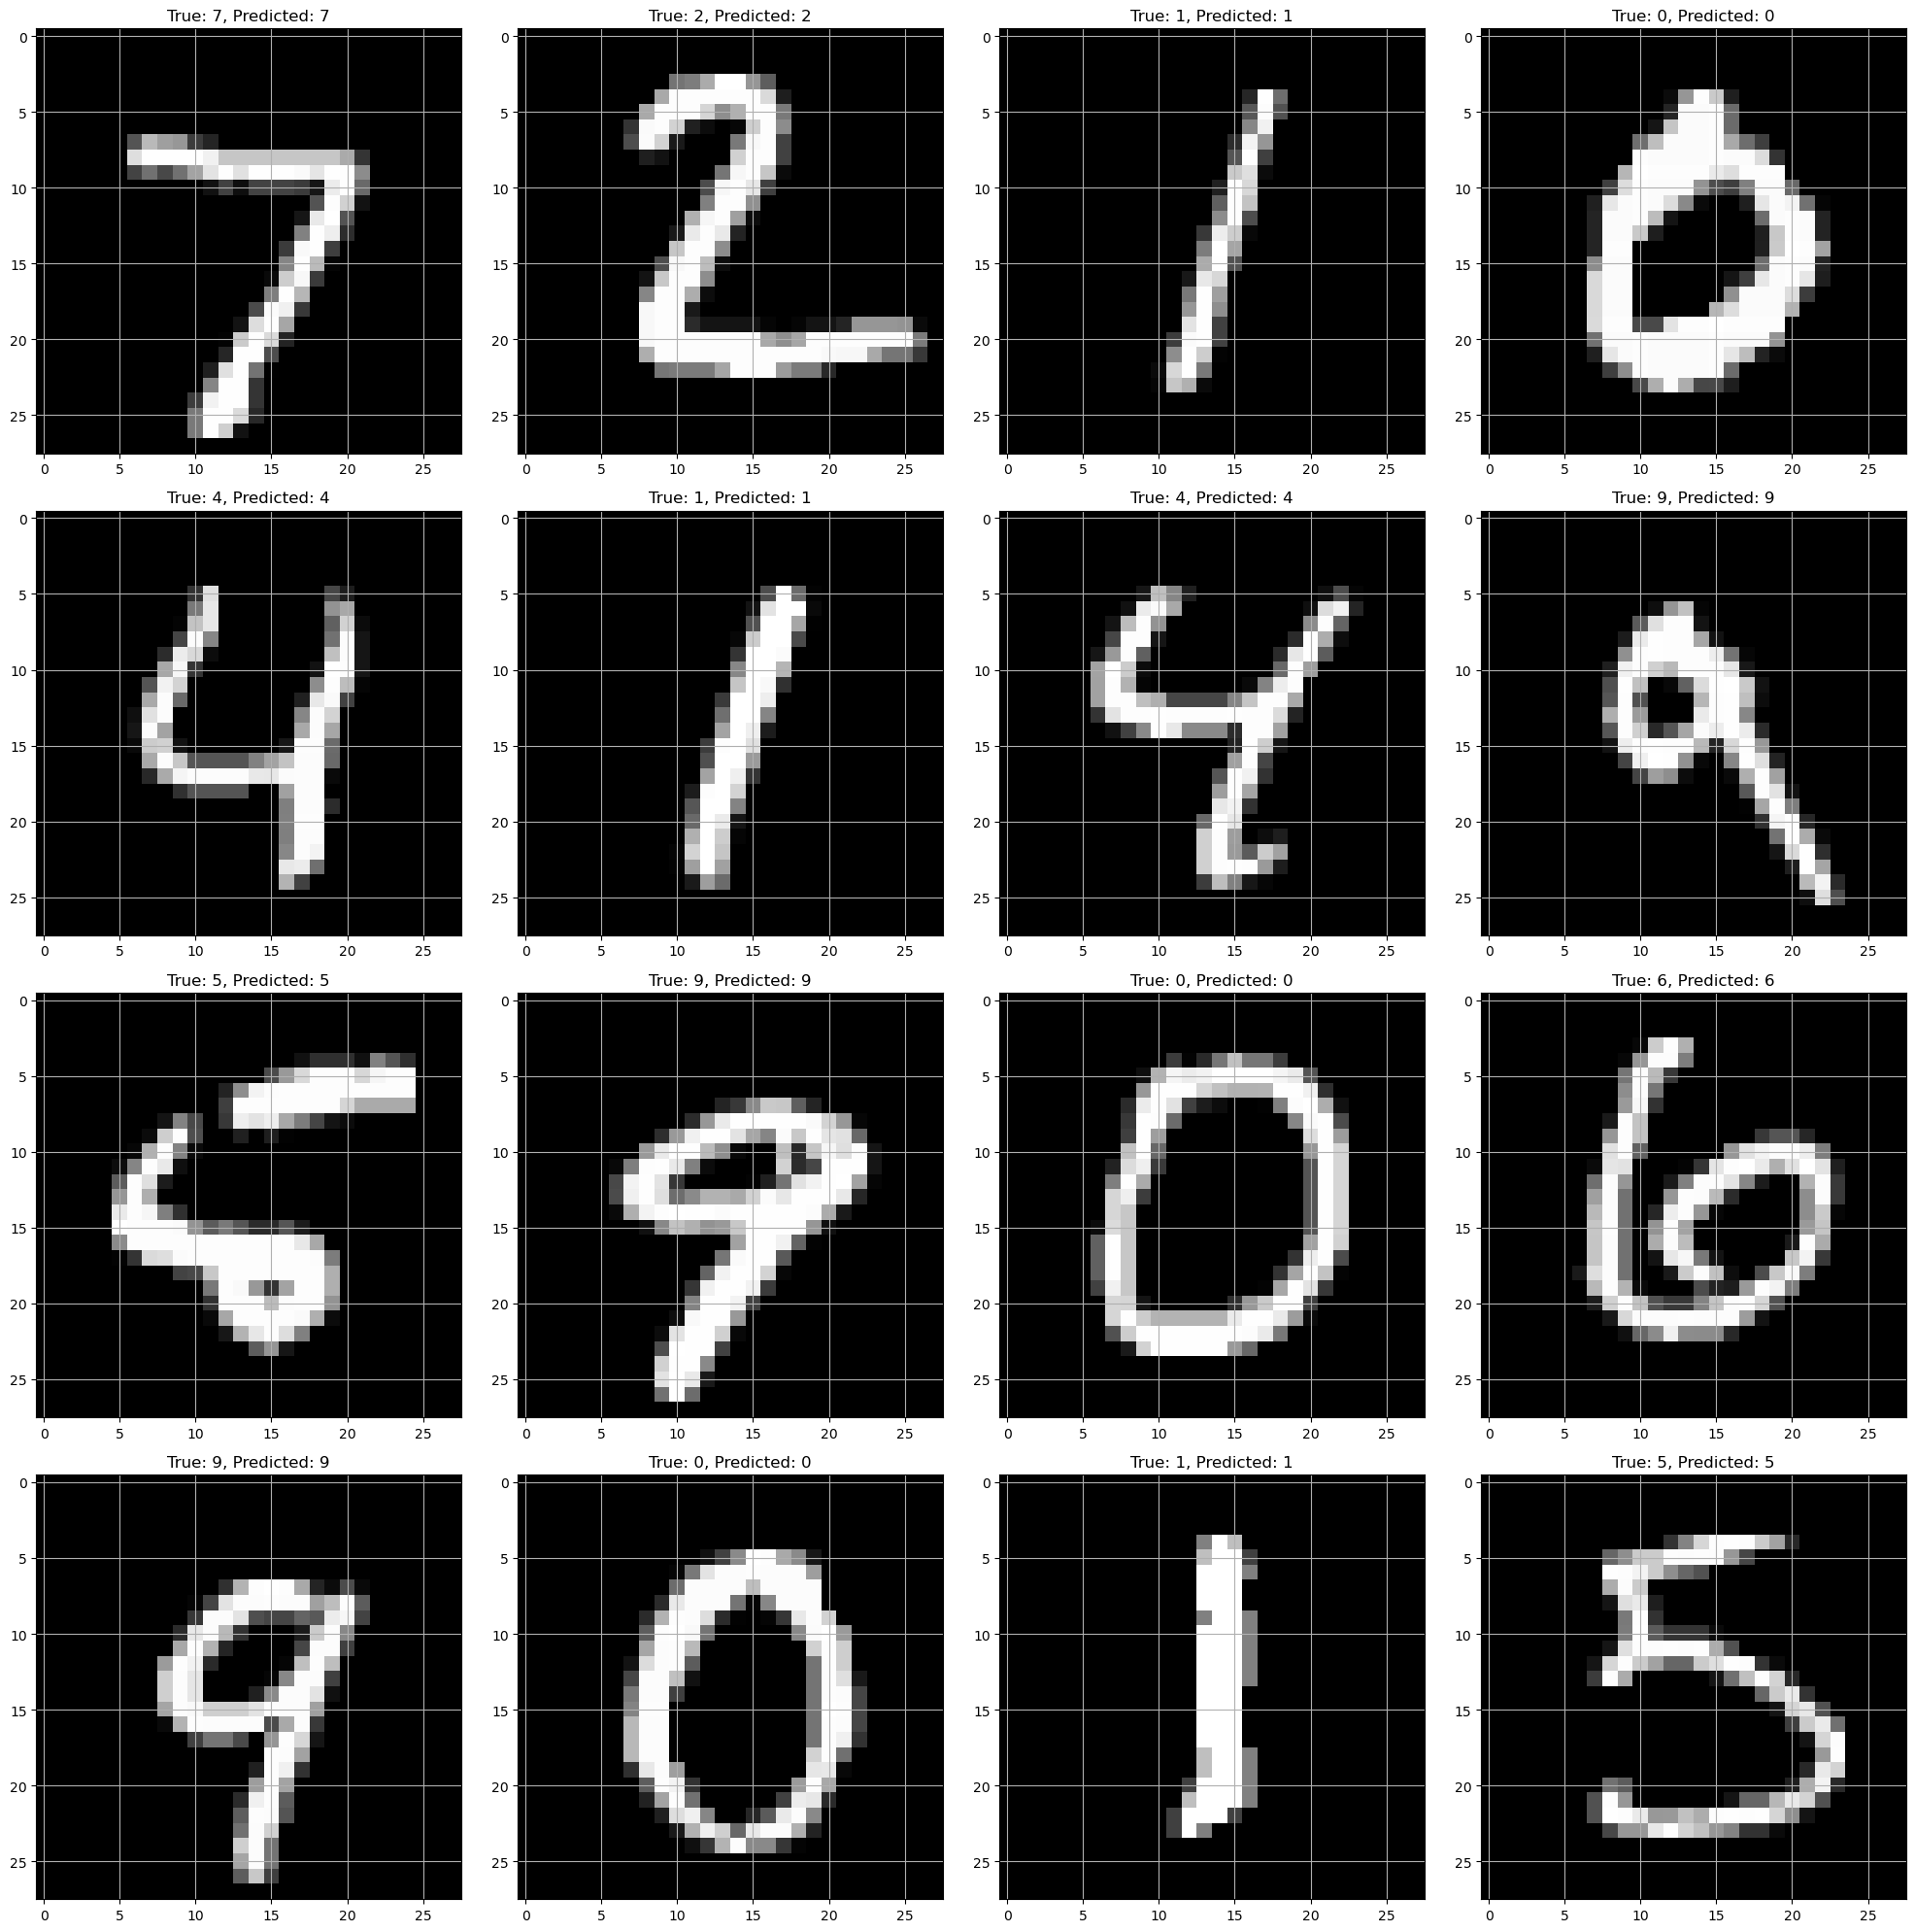

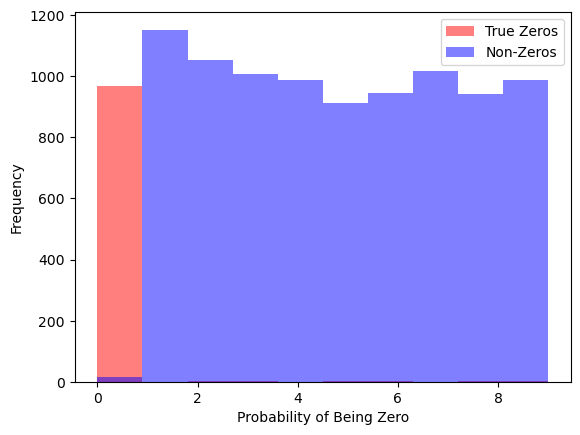

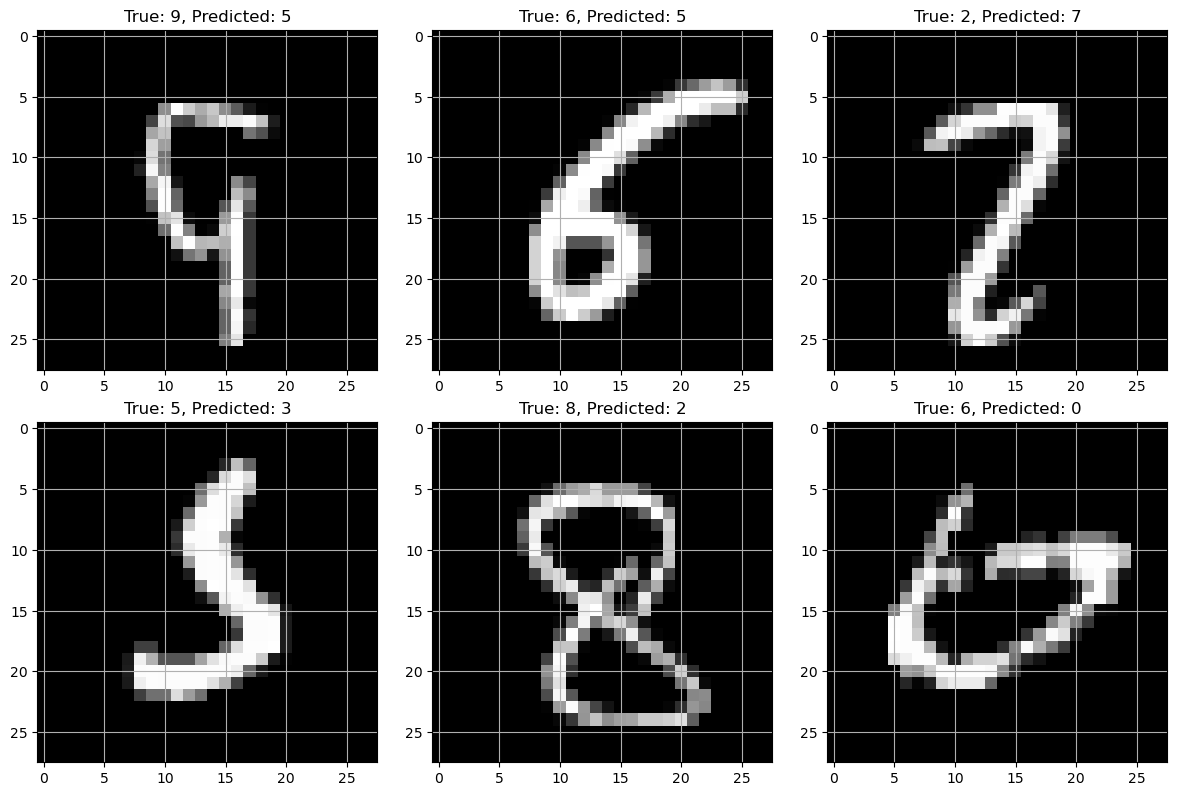

In [141]:
evaluate(X_test, Y_test)

313/313 [==============================] - 0s 899us/step
Coefficient of determination: 0.95
Mean squared error: 0.40
Mean absolute error: 0.08


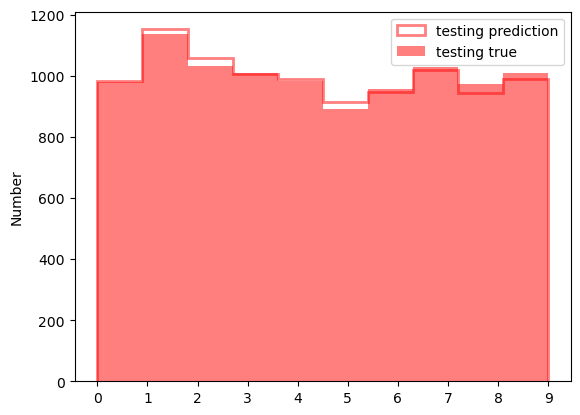

In [142]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


def more_evaluation(X_test, Y_test, ):

    Y_pred = model.predict(X_test)
    Y_pred = Y_pred.argmax(axis=1)
    Y_test = Y_test.argmax(axis=1)
    # Explained variance score: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2_score(Y_test, Y_pred))
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
    # The mean squared error
    print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, Y_pred))

    # predictions
    Y_pred.reshape(-1)

    plt.hist(Y_test, alpha=0.5, color='red', bins=10, align='mid')
    plt.hist(Y_pred, alpha=0.5, color='red', bins=10, histtype='step', linewidth=2, align='mid')
    plt.xticks(range(10))
    plt.xlabel('')
    plt.ylabel('Number')
    plt.legend(['testing prediction', 'testing true'], loc='upper right')
    plt.show()


more_evaluation(X_test, Y_test)


## Adding more Dense Layers and Dropout

### Task 3: Adding additional classification layers
* Add a dense layer between the flatten layer and the output layer
* Add a 25% dropout layer before the flatten layer
* Add a 50% dropout layer between the two dense layers
* Build the model, train the NN, plot the loss and accuracy evolution
* Evaluate the new model

In [143]:
from tensorflow.keras.layers import Dropout # type: ignore
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu',
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 dropout_2 (Dropout)         (None, 26, 26, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 21632)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               2769024   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,770,634
Trainable params: 2,770,634
No

In [144]:
new_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 9s 36ms/step - loss: 0.3187 - accuracy: 0.9055 - val_loss: 0.0893 - val_accuracy: 0.9728
Epoch 2/10
235/235 [==============================] - 8s 35ms/step - loss: 0.1214 - accuracy: 0.9643 - val_loss: 0.0635 - val_accuracy: 0.9788
Epoch 3/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0866 - accuracy: 0.9736 - val_loss: 0.0530 - val_accuracy: 0.9831
Epoch 4/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0716 - accuracy: 0.9782 - val_loss: 0.0522 - val_accuracy: 0.9828
Epoch 5/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.0492 - val_accuracy: 0.9842
Epoch 6/10
235/235 [==============================] - 9s 37ms/step - loss: 0.0505 - accuracy: 0.9845 - val_loss: 0.0472 - val_accuracy: 0.9846
Epoch 7/10
235/235 [==============================] - 8s 35ms/step - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.0442 - val_accuracy: 0.9854

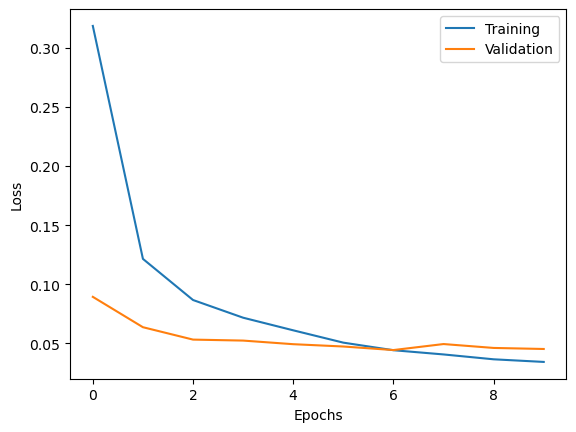

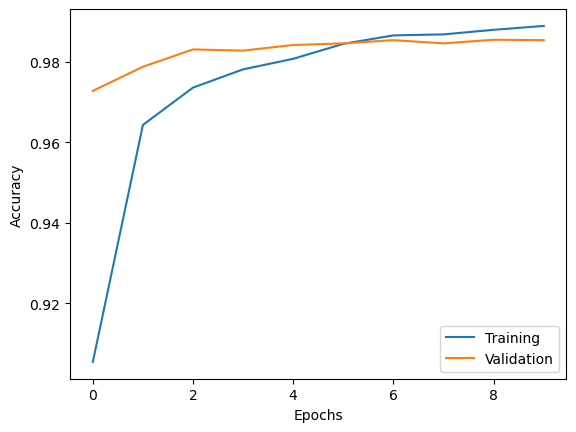

In [145]:
plot_history(new_history)

400/400 [==============================] - 1s 2ms/step - loss: 0.0451 - accuracy: 0.9854
[0.045100096613168716, 0.9854000210762024]
313/313 [==============================] - 0s 2ms/step
10000 10000 10000

 Accuracy Score =  0.9854

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      

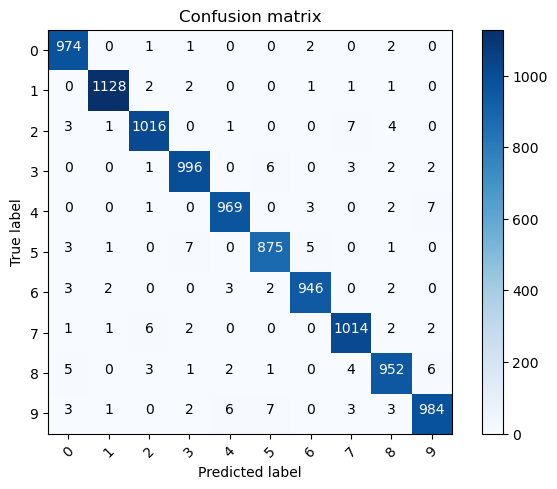

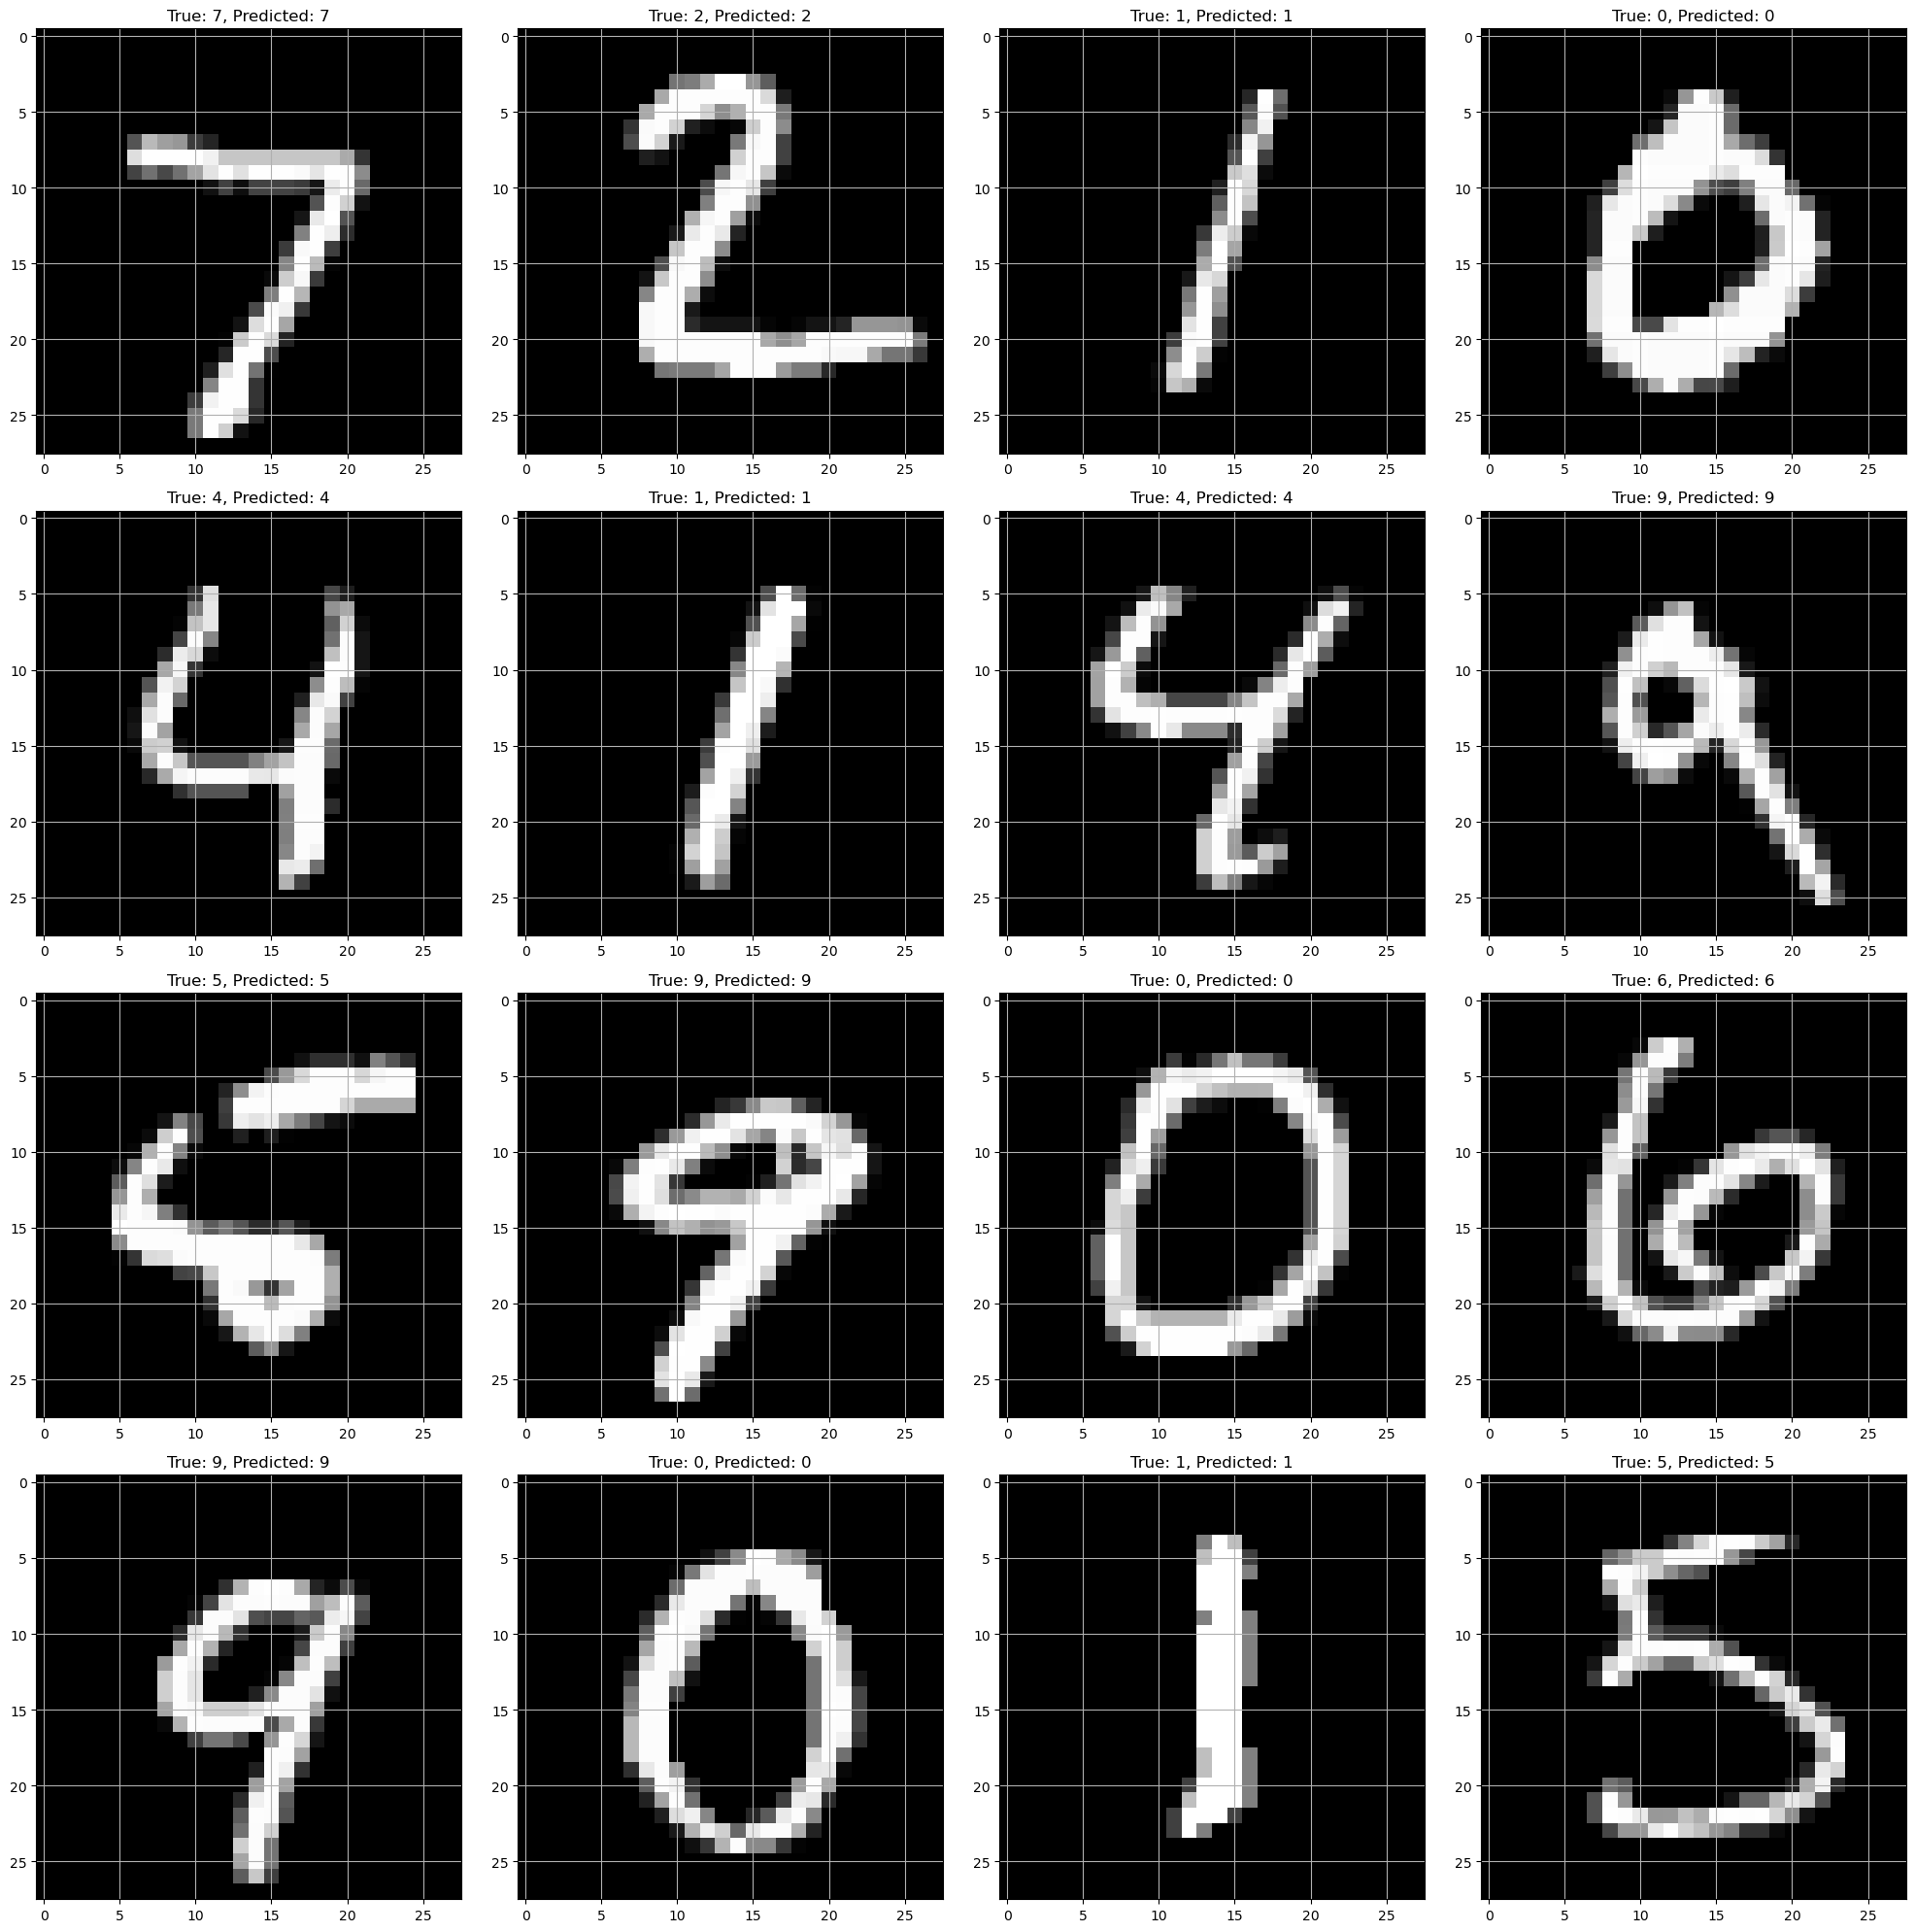

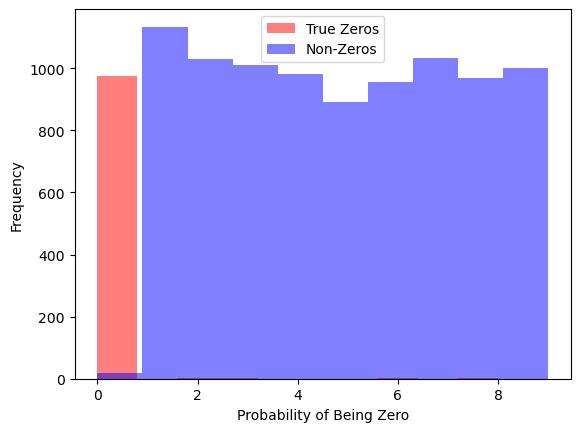

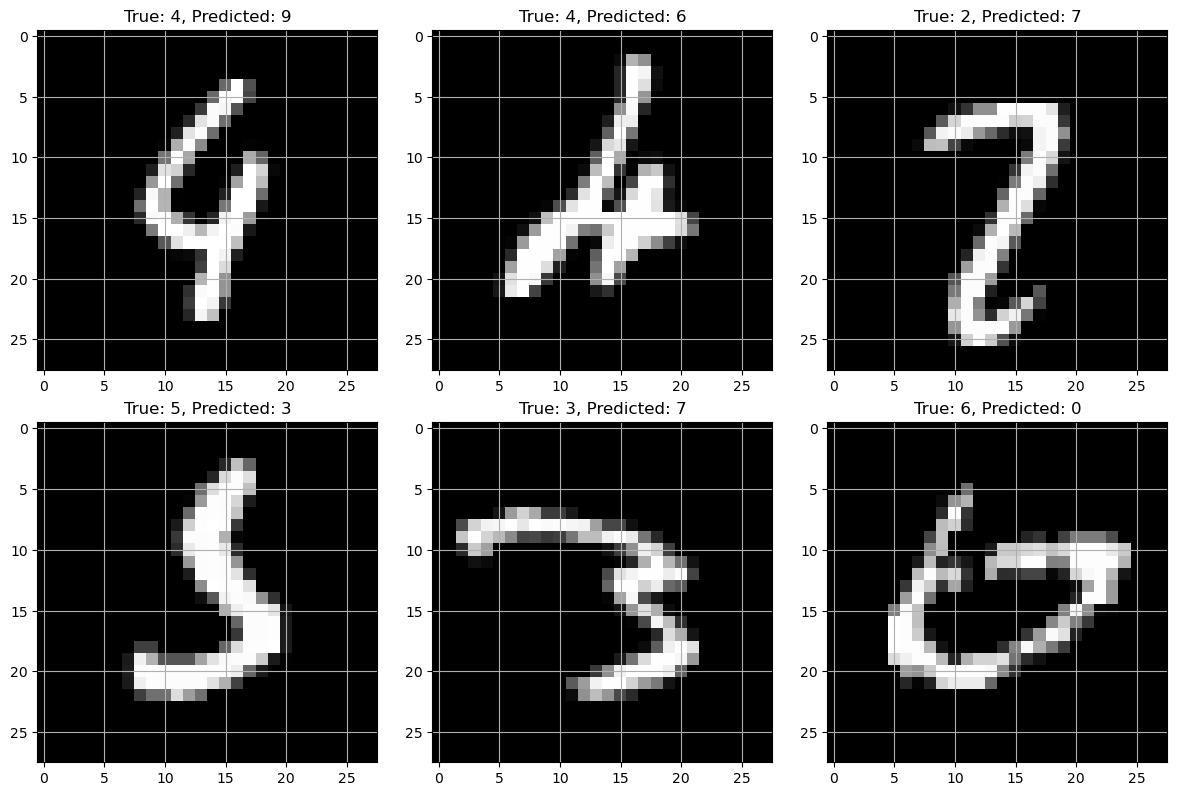

In [146]:
evaluate(X_test, Y_test)

313/313 [==============================] - 1s 2ms/step
Coefficient of determination: 0.97
Mean squared error: 0.28
Mean absolute error: 0.06


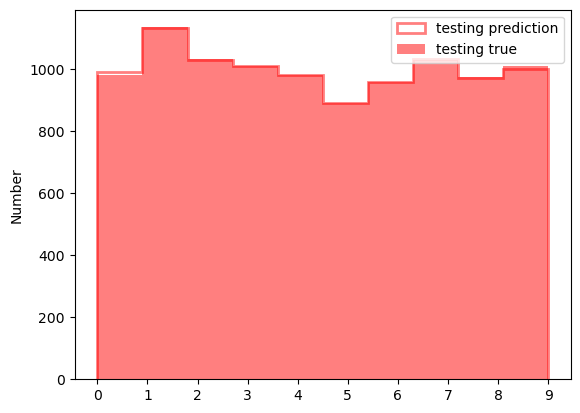

In [147]:
more_evaluation(X_test, Y_test)

# Adding an additional convolution layer and a pooling layer

### Task 4: Adding additional classification layers
* Add another `Conv2D` layer after the first convolutional layer with 64 filters, 3x3 kernel and `valid` (no) padding
* Add a `MaxPooling2D` layer with a 2x2 pooling size
* Build the model, train the NN, plot the loss and accuracy evolution
* Evaluate the new model

In [151]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu',
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1179776   
                                                      

### Training

In [152]:
third_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 23s 98ms/step - loss: 0.2874 - accuracy: 0.9133 - val_loss: 0.0575 - val_accuracy: 0.9817
Epoch 2/10
235/235 [==============================] - 24s 101ms/step - loss: 0.0910 - accuracy: 0.9730 - val_loss: 0.0387 - val_accuracy: 0.9862
Epoch 3/10
235/235 [==============================] - 25s 105ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.0369 - val_accuracy: 0.9883
Epoch 4/10
235/235 [==============================] - 25s 108ms/step - loss: 0.0550 - accuracy: 0.9830 - val_loss: 0.0309 - val_accuracy: 0.9904
Epoch 5/10
235/235 [==============================] - 26s 111ms/step - loss: 0.0470 - accuracy: 0.9853 - val_loss: 0.0262 - val_accuracy: 0.9919
Epoch 6/10
235/235 [==============================] - 26s 109ms/step - loss: 0.0404 - accuracy: 0.9873 - val_loss: 0.0304 - val_accuracy: 0.9900
Epoch 7/10
235/235 [==============================] - 25s 106ms/step - loss: 0.0381 - accuracy: 0.9879 - val_loss: 0.0297 - val_acc

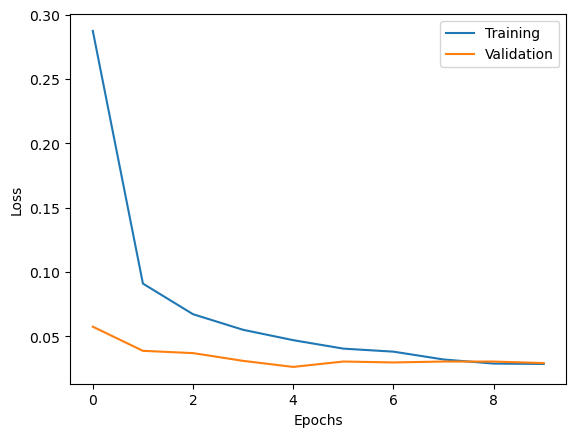

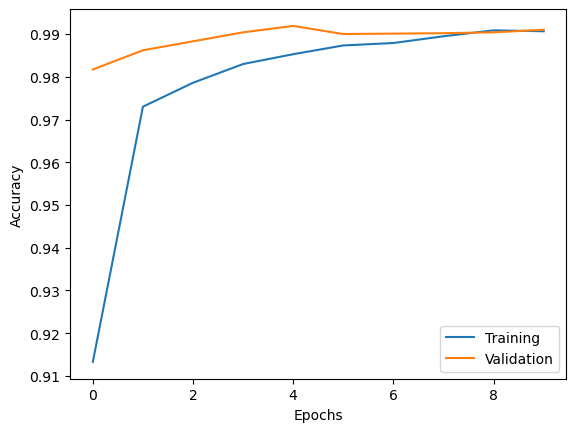

In [153]:
plot_history(third_history)

### Evaluating

400/400 [==============================] - 1s 3ms/step - loss: 0.0292 - accuracy: 0.9910
[0.029196349903941154, 0.9909999966621399]
313/313 [==============================] - 1s 4ms/step
10000 10000 10000

 Accuracy Score =  0.991

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0

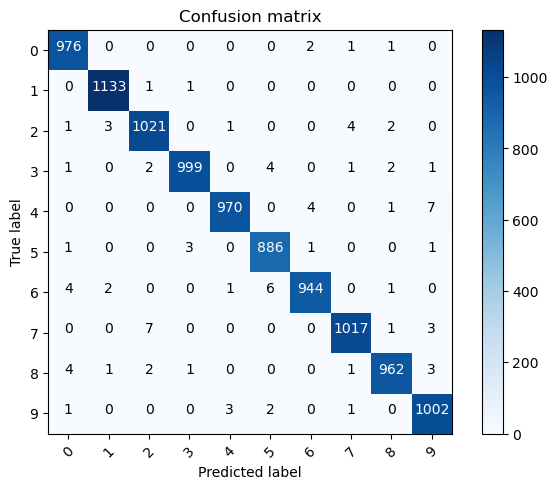

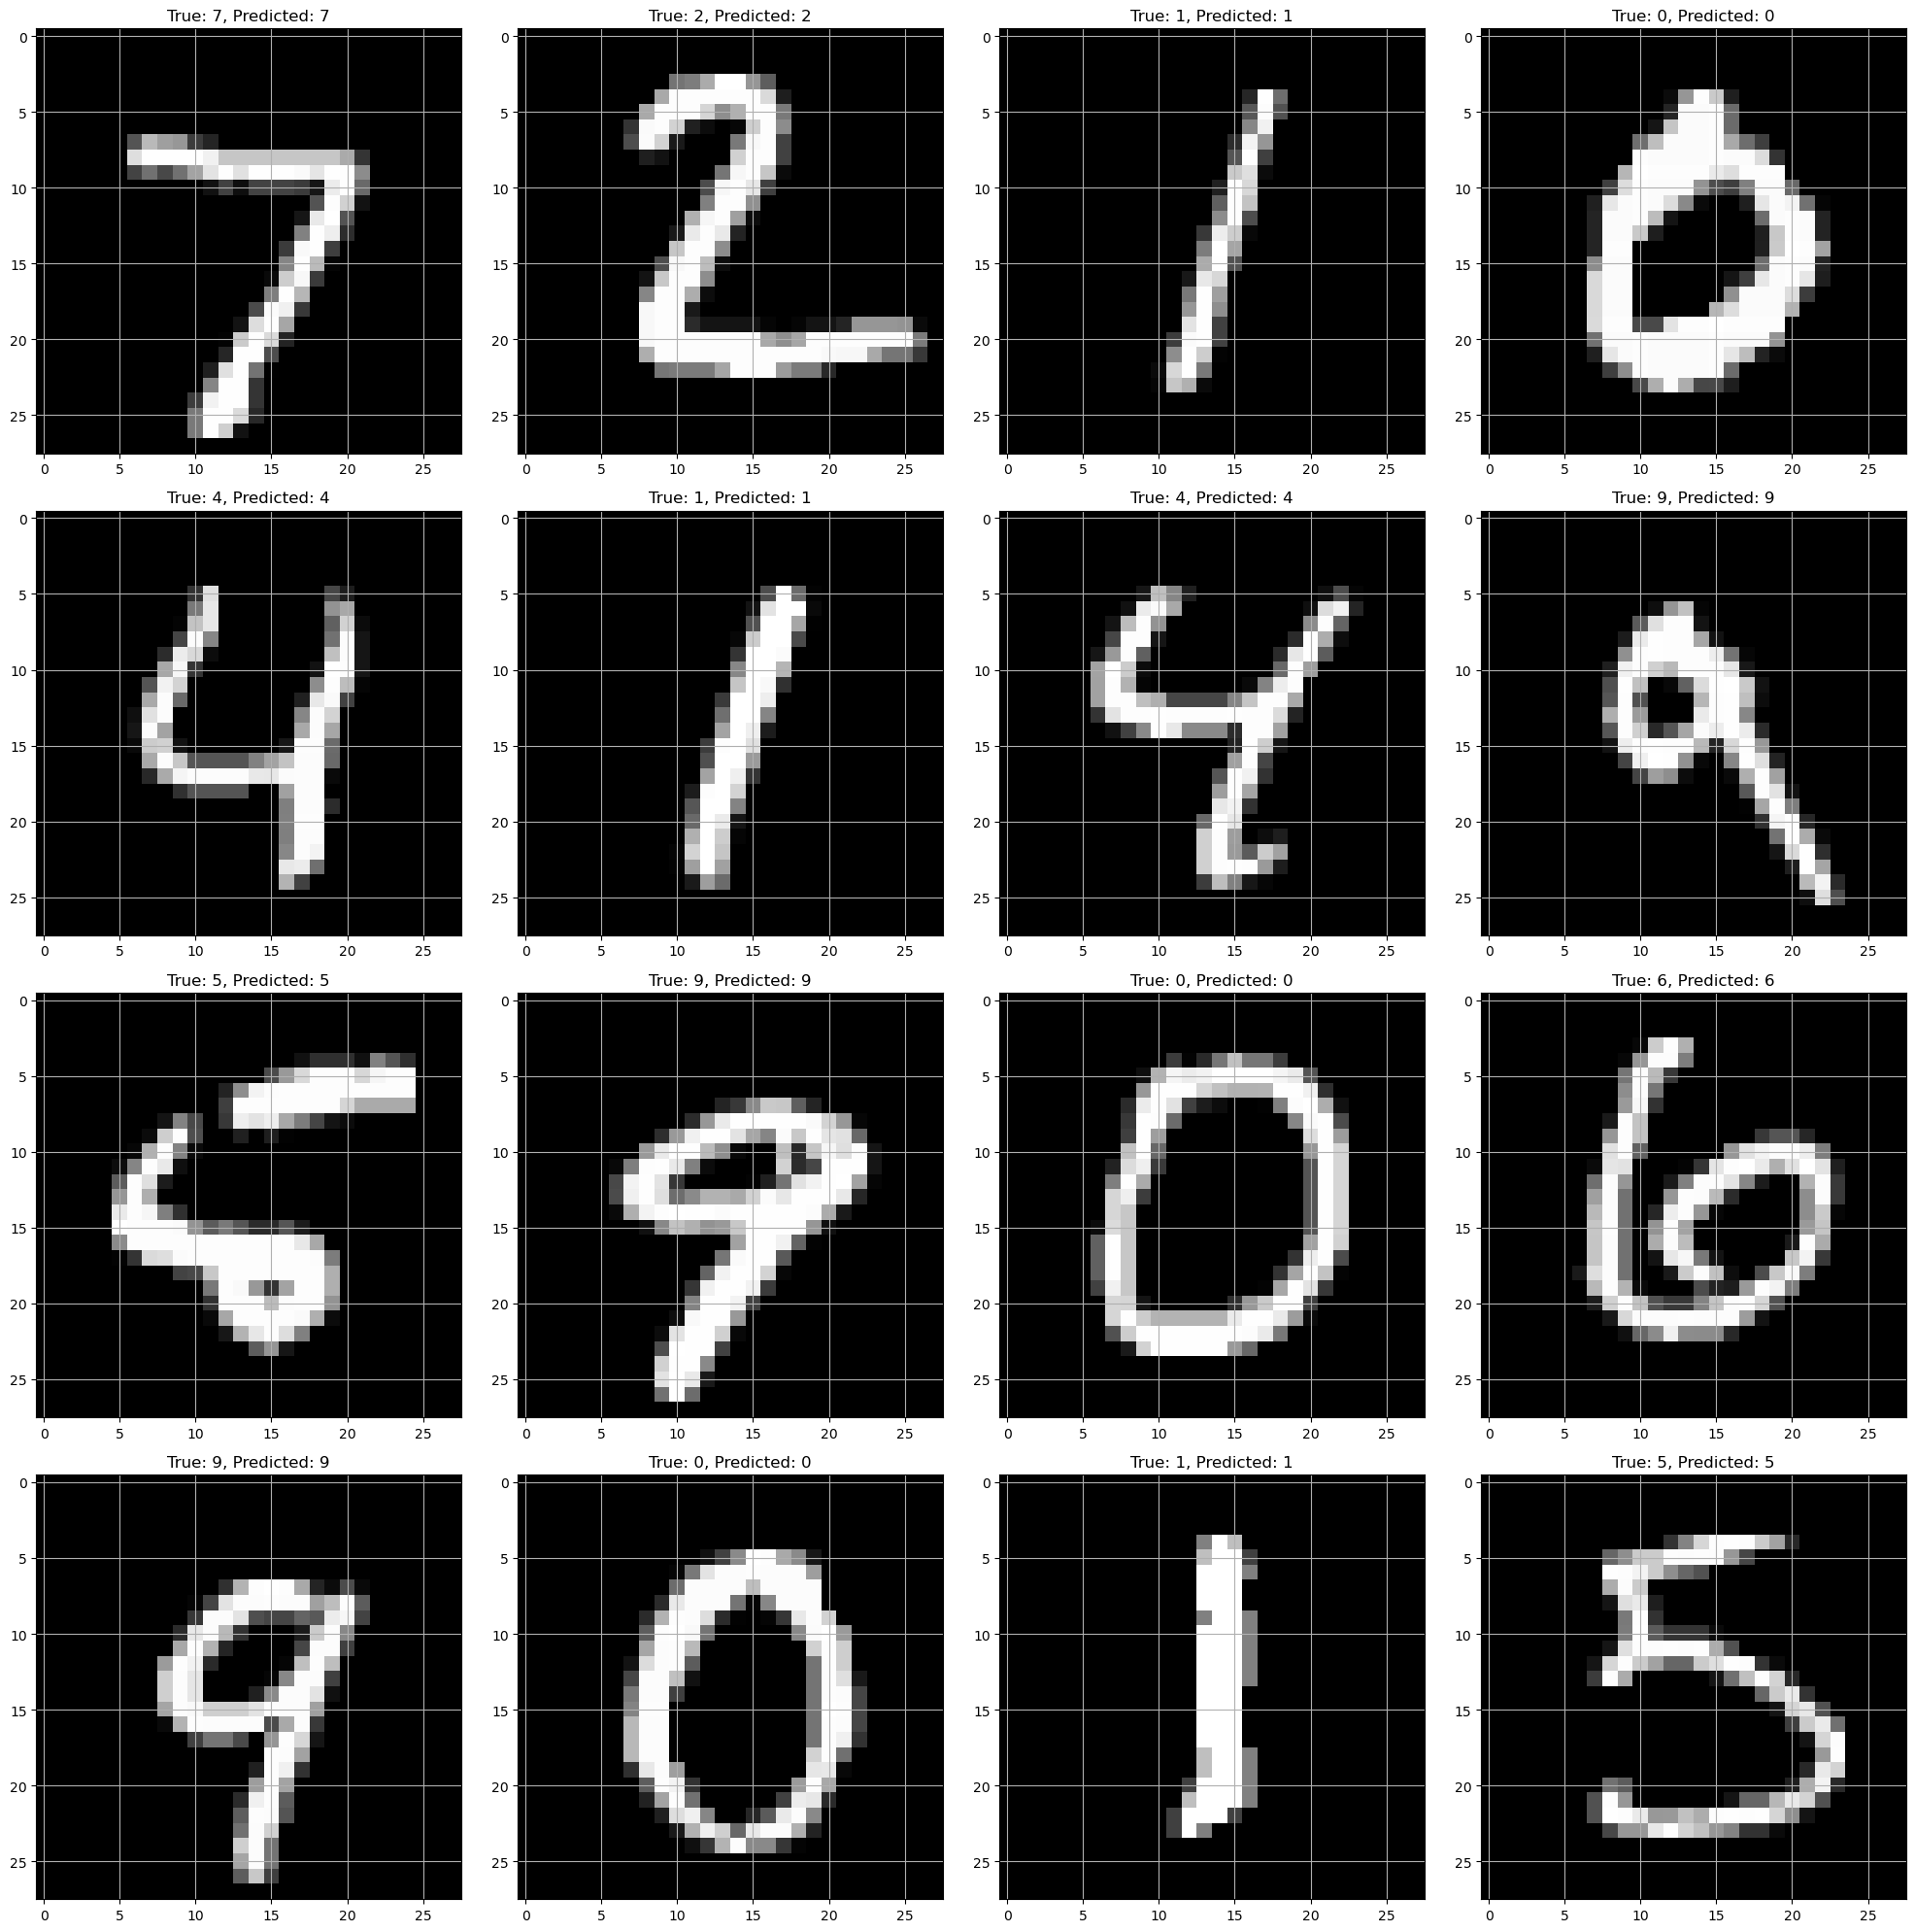

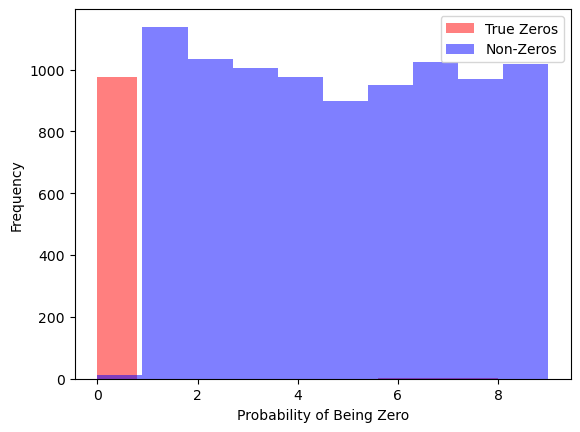

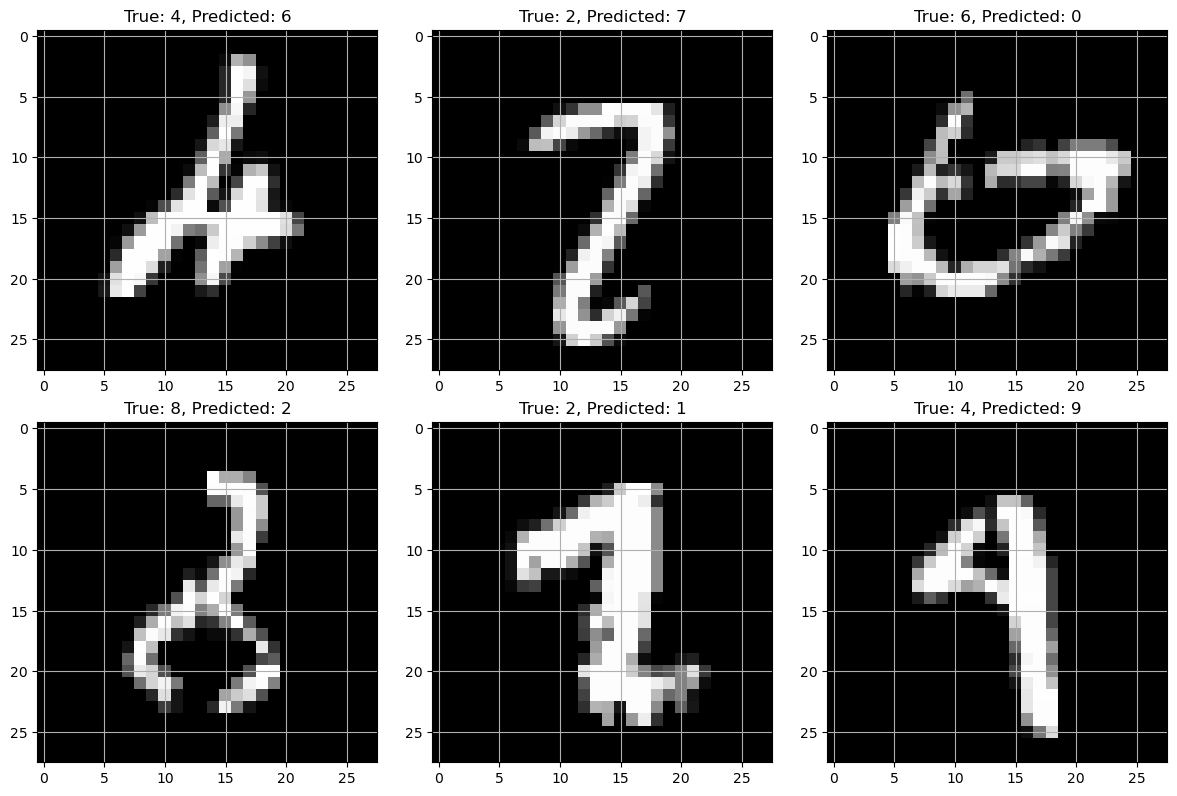

In [154]:
evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step
Coefficient of determination: 0.98
Mean squared error: 0.18
Mean absolute error: 0.03


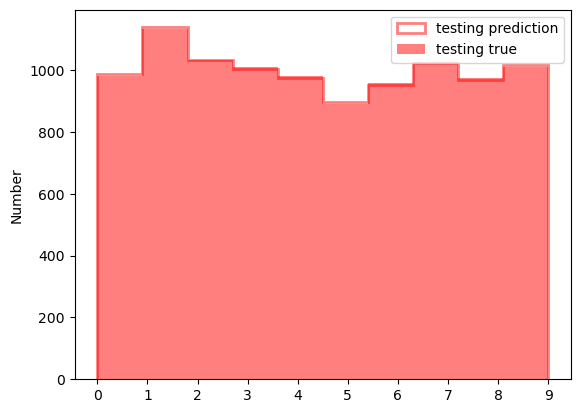

In [155]:
more_evaluation(X_test, Y_test)

---

# Bonus: Understanding Convolutional Layers Structure

We will inspect and understand the convolutional layer of our previously defined quite shallow CNN, which contains two [Convolution, Convolution, MaxPooling] stages, and two Dense layers.


### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user).

In this case, it is a `28x28` image with one color channel.

The first convolutional layer has the `padding` set to `same`, so its output width and height will remain the same. The number of output channel will be equal to the number of filters learned by the layer, 32.

The following convolutional layer, instead, have the default `padding`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel.

`MaxPooling` layers, instead, reduce width and height of the input tensor, but keep the same number of channels.

`Activation` and `Dropout` layers, of course, don't change the shape.

In [ ]:
for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

### Understanding weights shape

In the same way, we can visualize the shape of the weights learned by each layer.

In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object.

This will return a list with two elements, the first one being the **weight tensor** and the second one being the **bias vector**.

In particular:

- **MaxPooling layer** don't have any weight tensor, since they don't have learnable parameters.


- **Convolutional layers**, instead, learn a $(n_o, n_i, k, k)$ weight tensor, where $k$ is the size of the kernel, $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned.

For each of the $n_o$ filters, a bias is also learned.


- **Dense layers** learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [ ]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Layer", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)